## Final Project Module 3: Statistical Analysis and Hypothesis Testing


* Student name: Francis Morales
* Instructor name: Eli Thomas
* Blog post URL: 
* Presentation Link:


## Project Northwind Database

<img src="Northwind_ERD_updated.png" height="100%" width="100%">

In [233]:
# import libraries
import pandas as pd
import numpy as np
import sqlite3 as sql

import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [160]:
# Create a connection object that represents the database
cnx = sql.connect(r'Northwind_small.sqlite')
#Create a cursor instance to use execute/fetchall methods
c = cnx.cursor()

In [14]:
#Every SQLite database has an SQLITE_MASTER table that defines the schema for the database
#For tables, the type field will always be 'table' and the name field will be the name of the table
c.execute(''' SELECT name FROM sqlite_master WHERE type = 'table';''')

table_names = c.fetchall()
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [258]:
#Function taken from BRITTA BETTENDORF
#Function that prints the columns of a table and each column's type
def get_columns_info(table_name):    
    """ Function takes in table name and prints columns' names
    and datatypes """
    
    cols_list = inspector.get_columns(table_name)    
    print(f"Table Name: {table_name}\n")
    for col in cols_list:
        print(f"Name: {col['name']} \t Type: {col['type']}")

## Hypothesis 1 - Do customers with more orders placed generate higher sales amounts?
- $H_0: \mu_1 = \mu_2$ Customers with more orders placed spend the same amount on average as customers with less orders placed
- $H_a: \mu_1 > \mu_2$ Customers with more orders placed spend more than customers with less orders placed

### Data Exploration

In [261]:
#Get the total sales amount per customer ID
#Get the count of number of orders placed by customer

data1 = pd.read_sql_query('''SELECT o.CustomerId, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount',
                            COUNT(o.Id) as 'CountOrders'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.CustomerId
                            ;''', cnx)

In [263]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
CustomerId     89 non-null object
TotalAmount    89 non-null float64
CountOrders    89 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [277]:
data1.head()

,CustomerId,TotalAmount,CountOrders
0,ALFKI,4273.0000,12
1,ANATR,1402.9500,10
2,ANTO,7023.9775,17
3,AROUT,13390.6500,30
4,BERGS,24927.5775,52


In [264]:
#get the median of frequency orders to create the samples
data1['CountOrders'].median()

20.0

In [265]:
#create 2 sample groups 
#sample groups are divided by the median order frequency (our independent variable)
#This will allow to check if the TotalAmount means between groups are significantly different
high_frequency = data1.loc[data1['CountOrders'] > data1['CountOrders'].median()]
low_frequency = data1.loc[data1['CountOrders'] <= data1['CountOrders'].median()]

#### Histogram to check normality

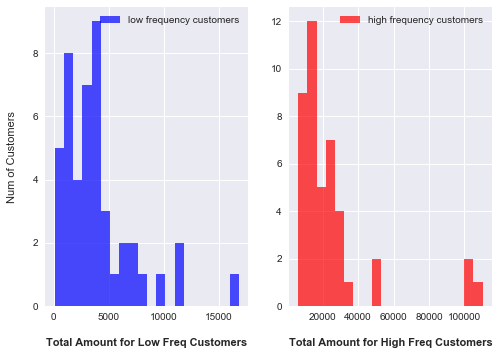

In [274]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(low_frequency['TotalAmount'], bins=20, color='b', alpha=0.7, label='low frequency customers')
ax1.set_xlabel('\nTotal Amount for Low Freq Customers', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(high_frequency['TotalAmount'], bins=20, color='r', alpha=0.7, label='high frequency customers')
ax2.set_xlabel('\nTotal Amount for High Freq Customers', fontweight='bold')
ax2.legend();

#### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [276]:
print(scs.shapiro(high_frequency['TotalAmount']), scs.shapiro(low_frequency['TotalAmount']))

(0.6320275068283081, 3.807205661843227e-09) (0.8364682793617249, 1.392168542224681e-05)


> With p-values below the alpha level (0.05) we reject H0 and have significant evidence to assume that the samples do not follow a normal distribution.

#### Levene test to check for equal variances
- H0: v1=v2

- Ha: v1!=v2

In [275]:
# Levene Test for testing homogeneity of variances
# I will be evaluating if the total amount comes from a normal distribution

scs.levene(high_frequency['TotalAmount'], low_frequency['TotalAmount'])

LeveneResult(statistic=11.818379956321802, pvalue=0.0009019045930232378)

> We have significant evidence to reject H0 and conclude that the variances in the samples are different.
Since the variances between the two groups are not equal, we cannot use a T-test

**After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality and equal variance assumptions.**

#### Monte Carlo Simulation

In [283]:
#get the mean difference 
mean_diff = high_frequency['TotalAmount'].mean() - low_frequency['TotalAmount'].mean()
mean_diff

21086.921466632968

- On average, high frequency customers spent $21086 more than low frequency customers.
- We will take 10000 random sample mean differences from our data and check if the random mean difference is greater than the study mean difference (high_frequency - low_frequency).
- If not many random sample mean differences are greater than the study mean difference, then we can conclude that the study mean difference is not due to chance
- We also calculate the p-value to check the percentage of random mean differences that are greater than the study mean difference

In [285]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0

for i in range(10000):
    sample_high = data1.sample(replace=False, n=len(high_frequency['TotalAmount']))
    sample_low = data1.drop(sample_high.index, axis=0)
    sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

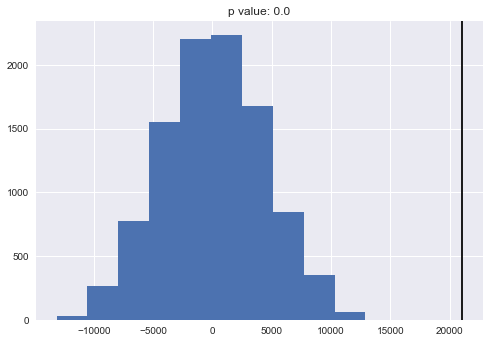

In [288]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

### Hypothesis 1: Conclusions & Business Recommendations

- A Shapiro test and a Levene test were used to check normality and equal variance assumptions. The results from these tests along with the plotted histograms confirmed that the data did not come from a normal distribution 
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.0, therefore we have significant evidence to reject H0
- The final conclusion is that customers with more orders placed spend more than customers with less orders placed

## Test 2

I want to check the best seller product per region

In [ ]:
#get all the products 
datatest2 = pd.read_sql_query('''SELECT o.CustomerId, o.OrderDate, 
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.CustomerId
                            ;''', cnx)

## Francis Hypothesis - Does order handling time affect the sales amount?

- H0 = Sales Amount for High order handling time >= Sales Amount for lower handling time 
- Ha = Sales Amount for High order handling time < Sales Amount for lower order handling time

Order handling time = ShippedDate - OrderedDate


In [187]:
#Get the total amount per order ID
#Get the order handling time in days per order ID
#handling time = ShippedDate - OrderDate

data = pd.read_sql_query('''SELECT o.Id as OrderId, o.CustomerId, o.OrderDate, o.ShippedDate, 
                            julianday(o.ShippedDate) - julianday(o.OrderDate) as "HandlingTime",
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.Id
                            ;''', cnx)

In [188]:
data.head()

,OrderId,CustomerId,OrderDate,ShippedDate,HandlingTime,TotalAmount
0,10248,VINET,2012-07-04,2012-07-16,12.0,440.00
1,10249,TOMSP,2012-07-05,2012-07-10,5.0,1863.40
2,10250,HANAR,2012-07-08,2012-07-12,4.0,1552.60
3,10251,VICTE,2012-07-08,2012-07-15,7.0,654.06
4,10252,SUPRD,2012-07-09,2012-07-11,2.0,3597.90


In [191]:
#get the median amount to create the samples
data['HandlingTime'].median()

7.0

In [194]:
#create 2 sample groups 
#sample groups are divided by the median handling time. This will allow to check
#if the Total_Amount means between groups are significantly different

large_handling = data.loc[data['HandlingTime'] > data['HandlingTime'].median()]

small_handling = data.loc[data['HandlingTime'] <= data['HandlingTime'].median()]


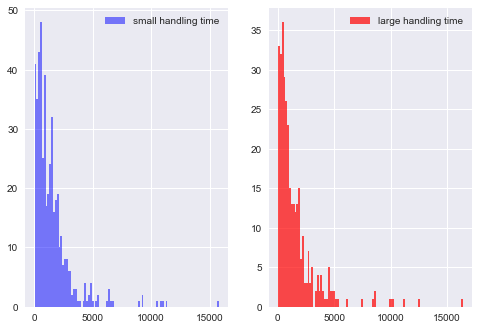

In [227]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(small_handling['TotalAmount'], bins=100, color='b', alpha=0.5, label='small handling time')
ax2.hist(large_handling['TotalAmount'], bins=100, color='r', alpha=0.7, label='large handling time')
ax1.legend()
ax2.legend();

In [242]:
#Take some sample means 
sample_means_small = []
sample_means_large = []

for i in range(50):
    samp = np.random.choice(small_handling['TotalAmount'], size=50).mean()
    sample_means_small.append(samp)
    
for i in range(50):
    samp = np.random.choice(large_handling['TotalAmount'], size=50).mean()
    sample_means_large.append(samp)

In [248]:
sd_small = np.std(sample_means_small, ddof=1)
sd_large = np.std(sample_means_large, ddof=1)
print(sd_small, sd_large)

224.10302291338158 258.322114456781


In [249]:
print(sd_small, np.std(sample_means_small))
print(sd_large, np.std(sample_means_large))

224.10302291338158 221.8506740610389
258.322114456781 255.72584640797226


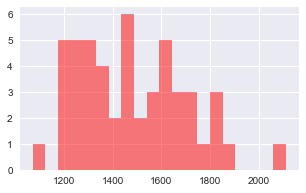

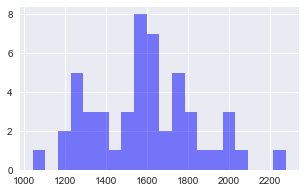

In [253]:
plt.figure(figsize=(5, 3))
plt.hist(sample_means_small, bins=20, color='r', alpha=0.5)
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(sample_means_large, bins=20, color='b', alpha=0.5)
plt.show();

#### Using Shapiro test for normality
- H0: distribution is normal
- Ha: distribution is not normal

In [257]:
print(scs.shapiro(sample_means_small), scs.shapiro(sample_means_large))

(0.9694462418556213, 0.21973472833633423) (0.9831778407096863, 0.6913372278213501)


With p-values greater than 0.05 we faild to reject H0; therefore, we have enough evidence to believe that the sample means come from a normal distribution.

#### Using the Levene test for equal variances of 2 distributions
- H0: v1=v2

- Ha: v1!=v2